# SQLAlchemy, Sqlite, and Dates

## Setup

In [20]:
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pandas as pd

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [21]:
engine = create_engine("sqlite:///../Resources/dow.sqlite", echo=False)

In [22]:
engine.execute('SELECT * FROM dow LIMIT 5').fetchall()

[(1, 1, 'AA', '2011-01-07', 15.82, 16.72, 15.78, 16.42, 239655616, None),
 (2, 1, 'AA', '2011-01-14', 16.71, 16.71, 15.64, 15.97, 242963398, None),
 (3, 1, 'AA', '2011-01-21', 16.19, 16.38, 15.6, 15.79, 138428495, None),
 (4, 1, 'AA', '2011-01-28', 15.87, 16.63, 15.82, 16.13, 151379173, None),
 (5, 1, 'AA', '2011-02-04', 16.18, 17.39, 16.18, 17.14, 154387761, None)]

In [23]:
inspector = inspect(engine)
columns = inspector.get_columns('dow')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
quarter INTEGER
stock TEXT
date TEXT
open_price FLOAT
high_price FLOAT
low_price FLOAT
close_price FLOAT
volume INTEGER
percent_change FLOAT


## Reflect and query dates

In [24]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Dow = Base.classes.dow

In [25]:
session = Session(engine)

## Analysis

Analyze the Average prices (open, high, low, close) for all stocks in the Month of May

In [27]:
# Query for the stock and average prices (open, high, low, close) 
# for all stock in the month of May
# Sort the result by stock name
sel = [Dow.stock, 
       func.avg(Dow.open_price), 
       func.avg(Dow.high_price), 
       func.avg(Dow.low_price), 
       func.avg(Dow.close_price)]
may_averages = session.query(*sel).\
    filter(func.strftime("%m", Dow.date) == "05").\
    group_by(Dow.stock).\
    order_by(Dow.stock).all()
may_averages

[('AA', 16.8475, 17.3375, 16.4175, 16.747500000000002),
 ('AXP', 49.89750000000001, 51.07, 49.315, 50.5025),
 ('BA', 78.7175, 79.2175, 76.8825, 78.2125),
 ('BAC', 12.0, 12.235, 11.7325, 11.8775),
 ('CAT', 108.5525, 110.5975, 104.045, 106.4),
 ('CSCO', 17.067500000000003, 17.255000000000003, 16.5925, 16.8575),
 ('CVX', 103.9725, 105.72749999999999, 100.4575, 102.76249999999999),
 ('DD', 53.9625, 54.9225, 52.14, 53.21),
 ('DIS', 42.3, 42.8175, 41.11749999999999, 41.900000000000006),
 ('GE', 19.96, 20.175, 19.4875, 19.740000000000002),
 ('HD', 36.765, 37.51, 36.504999999999995, 36.7625),
 ('HPQ', 39.315, 40.14, 37.8425, 38.54),
 ('IBM', 169.7025, 171.58, 166.9375, 169.11749999999998),
 ('INTC', 23.0975, 23.67, 22.652500000000003, 23.0225),
 ('JNJ', 65.6575, 66.8475, 65.0575, 66.08749999999999),
 ('JPM', 44.015, 44.709999999999994, 43.019999999999996, 43.527499999999996),
 ('KO', 67.5775, 68.32499999999999, 66.75750000000001, 67.4725),
 ('KRFT', 34.305, 35.0225, 33.945, 34.7375),
 ('MCD', 

In [28]:
# Plot the Results in a Matplotlib bar chart
df = pd.DataFrame(may_averages, columns=['stock', 'open_avg', 'high_avg', 'low_avg', 'close_avg'])
df.head()

,stock,open_avg,high_avg,low_avg,close_avg
0,AA,16.8475,17.3375,16.4175,16.7475
1,AXP,49.8975,51.0700,49.3150,50.5025
2,BA,78.7175,79.2175,76.8825,78.2125
3,BAC,12.0000,12.2350,11.7325,11.8775
4,CAT,108.5525,110.5975,104.0450,106.4000


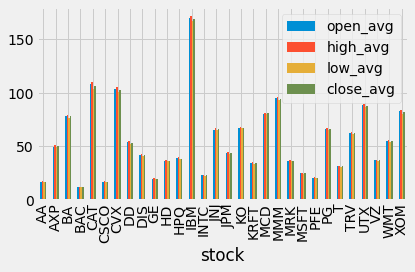

In [29]:
df.set_index('stock', inplace=True)
df.plot.bar()
plt.tight_layout()
plt.show()

### Bonus
Calculate the high-low peak-to-peak (PTP) values for `IBM` stock after `2011-05-31`. 
* Note: high-low PTP is calculated using `high_price` - `low_price`
* Use a DateTime.date object in the query filter
* Use list comprehension to create a list of dictionaries from the query results
* Create a dataframe from the list of dictionaries
* Use the `boxplot()` method on the dataframe to plot PTP distribution statistics

In [30]:
# Design a query to calculate the PTP for stock `IBM` after May, 2011
import datetime as dt

date = dt.datetime(2011, 5, 31)

results = session.query(Dow.high_price - Dow.low_price, 
                        Dow.date).\
                  filter(Dow.date > date).filter(Dow.stock == 'IBM').all()

# List comprehension solution
ptp_rows = [{"Date": result[1], "PTP": result[0]} for result in results]
ptp_rows

[{'Date': '2011-06-03', 'PTP': 5.759999999999991},
 {'Date': '2011-06-10', 'PTP': 3.0900000000000034},
 {'Date': '2011-06-17', 'PTP': 3.579999999999984},
 {'Date': '2011-06-24', 'PTP': 3.219999999999999}]

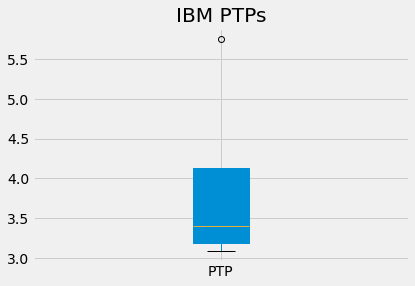

In [31]:
# Load the list comprehension rows into a dataframe, set the index to the date, and plot the PTPs
pd.DataFrame(ptp_rows).set_index("Date").boxplot(patch_artist=True)
plt.title("IBM PTPs")
plt.show()